# Modelo deeplearning: Detección y clasificación de basura

### Gustavo Alejandro Gutiérrez Valdes A01747869

### Introducción

Cada año, millones de toneladas de basura se generan y normalmente se manejan de manera inadecuada, lo que lleva a un aumento en la contaminación del suelo, el agua y el aire. Uno de los mayores retos en este contexto es la correcta clasificación de la basura, un proceso que suele ser manual, y donde el error humano siempre esta presente. La falta de una clasificación eficiente provoca que materiales reciclables y peligrosos se mezclen con residuos comunes, disminuyendo la efectividad del reciclaje y aumentando los riesgos ambientales.


Es por esto por lo que un modelo de IA entrenado para identificar y clasificar tipos de basura es crucial para mejorar la gestión de residuos y reducir el impacto ambiental. Al automatizar la correcta clasificación de los desechos, se optimizan los procesos de reciclaje, reducen los errores y se facilita el manejo adecuado de materiales reciclables y los que no. Esto no solo incrementa la eficiencia operativa y disminuye costos en instalaciones de reciclaje, sino que también protege a los trabajadores y fomenta la educación y la conciencia social sobre el manejo de residuos en las personas. La tecnología ayuda a promover la economía circular al reutilizar materiales y reducir la dependencia de recursos renovables, apoyando la sostenibilidad a largo plazo.

### Datos

Los datos fueron obtenidos de : [Kaggle: Garbage Classification](https://www.kaggle.com/datasets/quangtheng/garbage-classification-6-classes-775class)

Es un dataset compuesto por 6 clases, una por cada tipo de basura, que se separó en sets de train, validation y test. El primero tiene el 70% de las imagenes, y los otros dos sets tienen 15% cada uno. Como preprocesamiento, solo se tiene la redimensión de las imagenes a 224 x 224. 

Primero se tienen las importaciones de las paqueterías con las herramientas necesarias para poder crear, entrenar y mejorar el modelo de análisis de imagenes. Es importante el saber que estas paqueterías cambiarán conforme el avance del desarrollo del modelo, ya que pueden utilizarse más herramientas que no se han contemplado todavía.

Además, ya se tienen las jerarquía de carpetas con el acomodo de las imágenes (datos) para tener los distintos sets (train,validation y tests) que se utilizarán en el entrenamiento.

### Desarrollo del modelo

In [1]:
import pathlib
from tensorflow import keras #type: ignore
from keras.utils import image_dataset_from_directory, load_img, img_to_array #type: ignore
from keras.models import Sequential, load_model #type: ignore
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #type: ignore
from keras.layers import Dense, Conv2D, RandomBrightness, MaxPool2D, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, Reshape, RandomRotation, RandomContrast, multiply, Input #type: ignore
from keras.optimizers import Adam #type: ignore
from keras.regularizers import l2 #type: ignore
#from keras.preprocessing import image #type: ignore
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

class_names = ["Battery","Glass","Metal","Organic","Paper","Plastic"]

base_dir = pathlib.Path("ImagenesOrdenadas")


train_dataset = image_dataset_from_directory(
    base_dir / "train",
    image_size=(224, 224),
    batch_size=32,
   label_mode="int",
    )

validation_dataset = image_dataset_from_directory(
    base_dir / "validation",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")

test_dataset = image_dataset_from_directory(
    base_dir / "test",
    image_size=(224, 224),
    batch_size=32,
    label_mode="int")


Found 3252 files belonging to 6 classes.
Found 696 files belonging to 6 classes.
Found 702 files belonging to 6 classes.


Despues se hace una muestra de las imágenes y sus clases para corroborar que las cases y los objetos si corresponden

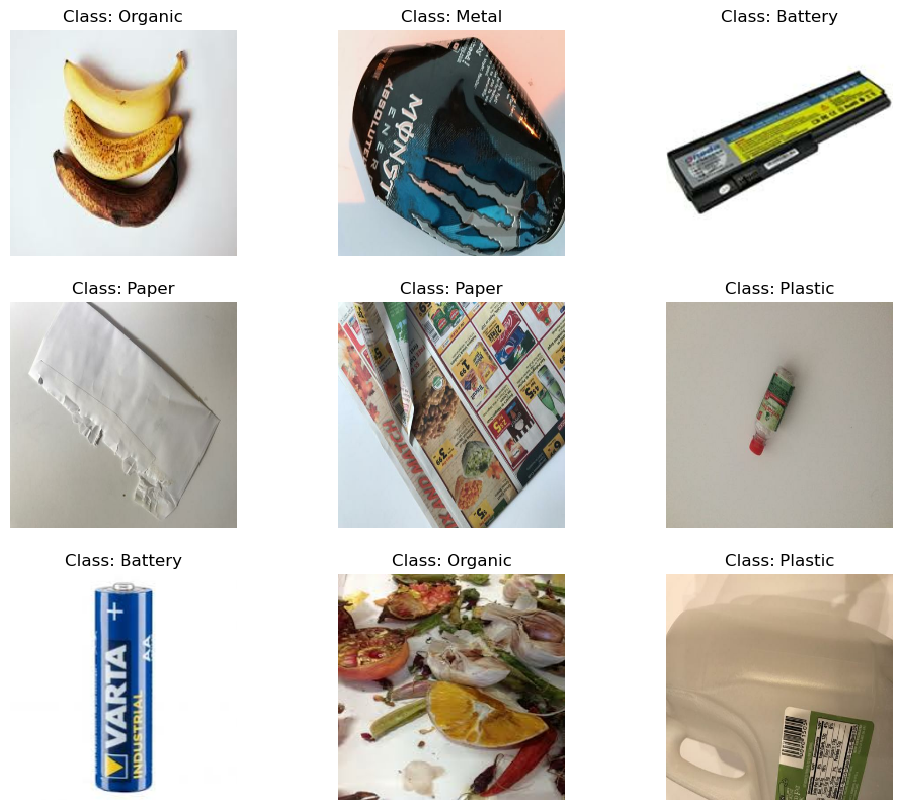

In [2]:
plt.figure(figsize=(12, 10))
index = 0
for element in train_dataset.take(1):
  for i in range(9):
    image = element[0][i]
    label = element[1][i]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image/255, interpolation="nearest")
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

Primero se desarrolla la clase del SEBLock (Squeeze-and-Excitation Block). Es una técnica de mejora para redes convolucionales que mejora la representación de características de la red al permitir el enfoque de manera adaptativa a la importancia de cada canal de características.

El SEBlock introduce un mecanismo de atención a nivel de canal, lo que permite que la red pueda aprender los canales más importantes para una tarea en particular, lo que representa una mejoría en la captación de características relevantes de las imagenes. Por otra parte, se realiza un ajuste de pesos dinámico para resaltar las características más relevantes e ignorar las que no.

Se tienen los dos métodos, __init__ y call, tanto que el primero se encarga de la creación del bloque con sus respectivas neuronas que se utilizan en la capa densa, el número de filtros de entrada, un average pooling (insertar definición) y la definición de las capas densas.

Por otra parte, el método call comprime la entrada a un vector de características, reduce la dimensionalidad para captar la interacción entre canales, devuelve el vector de peso escalado por cada canal, cambia la forma del vector de pesos para que sea compatible con la multiplicación con la entrada original y ajusta la importancia de cada canal multiplicando la entrada original por el vector se.

In [3]:
class SEBlock(keras.layers.Layer):
    def __init__(self, filters, reduction=16, **kwargs):
        super().__init__(**kwargs)
        self.global_avg_pool = GlobalAveragePooling2D()
        self.dense1 = Dense(filters // reduction, activation="relu")
        self.dense2 = Dense(filters, activation="sigmoid")

    def call(self, inputs):
        se = self.global_avg_pool(inputs)
        se = self.dense1(se)
        se = self.dense2(se)
        se = Reshape((1, 1, -1))(se)
        return multiply([inputs, se])

Siguiendo con el desarrollo, ahora implementamos una capa personalizada de Keras que cumplirá la función de una Residual Unit.

Las Residual Units ayudan a abordar el problema del desvanecimiento del gradiente, que es común en redes neuronales profundas. Al permitir que los gradientes fluyan directamente a través de conexiones de salto (skip connections), se facilita el entrenamiento de redes muy profundas. Además, permiten entrenar redes más profundas sin que se produzca una degradación en el rendimiento, lo que resulta en modelos más precisos.
Las conexiones de salto en las Residual Units permiten que las capas aprendan funciones de identidad, si es necesario. Esto simplifica el proceso de optimización y permite que las capas se entrenen de manera más efectiva. Al permitir que la información fluya sin obstáculos a través de la red, las Residual Units ayudan a capturar y representar características más complejas y detalladas en las imágenes, mejorando así el rendimiento general del modelo.

In [4]:
class ResidualUnit(keras.layers.Layer): 
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs) 
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.SeparableConv2D(filters, 3, strides=strides,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.SeparableConv2D(filters, 3, strides=1,
                                padding="same", use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1: 
            self.skip_layers = [
                keras.layers.SeparableConv2D(filters, 1, strides=strides,
                                    padding="same", use_bias=False),
                keras.layers.BatchNormalization()]
        self.se_block = SEBlock(filters)

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
            
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

La arquitectura que se busca implementar es una ResNet, que es una arquitectura que incluye unas unidades o capas llamadas bloques residuales. Estos bloques permiten que la información fluya más fácilmente a través de la red, solucionando el problema de degradación de la precisión que afecta a las redes neuronales profundas.

El siguiente modelo es la primera versión del la arquitectura ResNet. Se implementa una estructura más básica para analizar y comprender la dificultad del dataset y así poder tener una idea más clara de que partes de esta se tienen que reforzar o mejorar.

La función modelo_cnn toma dos parámetros: input_shape, que define la forma de las imágenes de entrada, y num_classes, que define el número de clases de salida. Después, se crea un modelo secuencial utilizando Sequential().

Se añaden capas de aumento de datos (RandomFlip y RandomRotation) para mejorar la generalización del modelo, capa convolucional con 32 filtros, un tamaño de kernel de 3x3, y una función de activación ReLU, una capa de normalización por lotes (BatchNormalization) y una capa de max-pooling con un tamaño de pool de 3x3 y un stride de 2. Se repite el proceso anterior con una capa convolucional de 64 filtros.

Se añaden varias unidades residuales (ResidualUnit) con diferentes números de filtros (2 x 64, 2 x 128,, 2 x 256) y strides (1 y 2). Además, se añade una capa de pooling global promedio para reducir las dimensiones espaciales de las características. Se añade una capa completamente conectada con 128 unidades y una función de activación ReLU.

Después, se añade una capa de dropout con una tasa de 0.5 para prevenir el sobreajuste y, por último, se añade la capa de salida con un número de unidades igual al número de clases y una función de activación softmax para la clasificación multiclase.

In [5]:
def modelo_cnn(num_classes=6):
    model = Sequential()
    
    model.add(Input(shape=(224, 224, 3)))
    model.add(RandomFlip("horizontal_and_vertical", input_shape=(224, 224, 3)))
    model.add(RandomRotation(0.2))

    model.add(Conv2D(32, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))

    model.add(Conv2D(64, (3, 3), activation='relu',kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=3, strides=2, padding="same"))
    
    model.add(ResidualUnit(64, strides=2))
    model.add(ResidualUnit(64, strides=2))
    model.add(ResidualUnit(128, strides=2))
    model.add(ResidualUnit(128, strides=2))
    model.add(ResidualUnit(256, strides=2))
    model.add(ResidualUnit(256, strides=2))
    
    # Aplanamiento de las características
    model.add(GlobalAveragePooling2D())

    # Capa completamente conectada
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))

    # Capa de salida
    model.add(Dense(num_classes, activation='softmax'))

    return model

modelo = modelo_cnn(num_classes=6)
modelo.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                        

Ahora se compilará el modelo con el optimizador de Adam y la función de pérdida sparse_categorical_crossentropy. 

Este optimizador Adam adapta el learning rate de forma individual para cada parámetro, lo que permite un ajuste más preciso y eficiente, además de proporcionar una convergencia más rápida en comparación con otros optimizadores. Por último, implementa automáticamente la reducción de los rates de aprendizaje de forma adaptativa para cada parámetro, lo que ayuda a controlar el sobreajuste y a mejorar la precisión durante el entrenamiento

Por otra parte, la función de pérdida elegida es la correcta de acuerdo a nuestra situación problema ya que permite utilizar etiquetas como enteros en lugar de vectores one-hot codificados, lo que simplifica el manejo de los datos y reduce la cantidad de memoria utilizada. Esta función es ideal para problemas de clasificación multiclase, donde cada muestra pertenece a una sola clase. Compara la predicción del modelo con la clase real y penaliza las diferencias para ajustar los pesos del modelo

Se monitoreará la métrica de accuracy para conocer la precisión del modelo, mientras que el learning rate es de 0.01 para comenzar la etapa exploratoria.

In [6]:
modelo.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Como callbacks, se utilizará el early_stopper y el model_checkpoint. El primero sirve para terminar el entrenamiento antes de tiempo dependiendo la mejoría de una métrica en específico, esto con el objetivo de no desperdiciar tanto tiempo en un ciclo que no va a tener mejores resultados.

Por otra parte, el model_checkpoint sirve para guardar el modelo que mejor desempeño tenga dependiendo una métrica en específico y no se pierda en un entrenamiento más largo, esto con el objetivo de tener las mejores predicciones. Este último se utilizará para la segunda versión (mejorada), ya que se presume que los entrenamientos serán aún más largos y se quiere evitar que se sobreescriba el mejor modelo de la primera versión con la final.

Al momento de entrenar, se utilizarán muy pocas epocas ya que se busca que sea una etapa más exploratoria, y solo se hará uso del callback de 'early_stopper'.

In [7]:

early_stopper = EarlyStopping(
    monitor='val_loss', 
    patience=10,          
    restore_best_weights=True  
)

model_checkpoint = ModelCheckpoint(
    'best_model_checkpoint.keras', save_best_only=True, monitor='val_loss', mode='min'
    )


# Entrenar el modelo
history = modelo.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[early_stopper]
)


Epoch 1/20
102/102 [==============================] - 107s 1s/step - loss: 1.6689 - accuracy: 0.3798 - val_loss: 1.8324 - val_accuracy: 0.1796
Epoch 2/20
102/102 [==============================] - 107s 1s/step - loss: 1.4404 - accuracy: 0.4606 - val_loss: 1.5612 - val_accuracy: 0.4052
Epoch 3/20
102/102 [==============================] - 107s 1s/step - loss: 1.3924 - accuracy: 0.4600 - val_loss: 2.8146 - val_accuracy: 0.2701
Epoch 4/20
102/102 [==============================] - 110s 1s/step - loss: 1.3389 - accuracy: 0.4877 - val_loss: 1.6129 - val_accuracy: 0.4698
Epoch 5/20
102/102 [==============================] - 117s 1s/step - loss: 1.3385 - accuracy: 0.4849 - val_loss: 2.4108 - val_accuracy: 0.3204
Epoch 6/20
102/102 [==============================] - 121s 1s/step - loss: 1.2891 - accuracy: 0.4908 - val_loss: 2.9150 - val_accuracy: 0.1868
Epoch 7/20
102/102 [==============================] - 118s 1s/step - loss: 1.2828 - accuracy: 0.5022 - val_loss: 4.4120 - val_accuracy: 0.3391

Ahora se graficarán los valores de precisión y pérdida durante el entrenamiento respecto a las épocas, para poder analizar el avance del modelo durante su aprendizaje y obtener conclusiones respecto a las mejoras que se deben implementar.

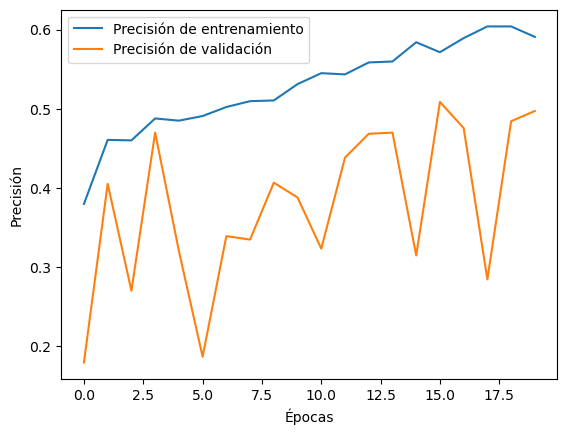

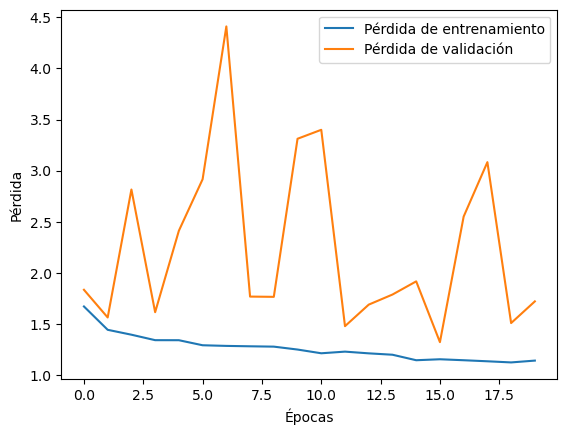

In [8]:
import matplotlib.pyplot as plt

# Gráfica de precisión
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfica de pérdida
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


De acuerdo a las gráficas anteriores, podemos notar lo siguiente:

La capacidad de generalización del modelo no es la más adecuada, ya que la precisión en la etapa de validación tiene una alta variabilidad, teniendo picos muy inconsistentes. Por parte del entrenamiento, el aprendizaje se nota más controlado de acuerdo a la forma de la línea azul, pero sigue estando en valores bastante mejorables

Por parte de la pérdida, esta decrece de manera suave y se mantienen estable, lo que podría significar que el aprendizaje del modelo es decente. Al igual que con la precisión, la pérdida en la etapa de validación es bastante inestable ya que cuenta con muchos picos y valles, lo que indica de igual forma que la capacidad de generalización es un punto a revisar. 

Estos resultados pueden deberse a los siguientes puntos:
- Podría requerir mayor regularización para evitar el comportamiento inconsistente durante la etapa de validación
- El learning rate podría ser muy alto, y esto resultaría en la forma errática de la precisión

Para conocer su desempeño en el ejercicio real, se utilizará esta primera versión para hacer predicciones con el set de test y ver cualés son los resultados que otorgaría el modelo.

In [9]:
predictions = modelo.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

22/22 [==============================] - 4s 136ms/step


Ahora se mostrarían las imágenes en cuestión, junto con su clase real y la predicción dada por el modelo.

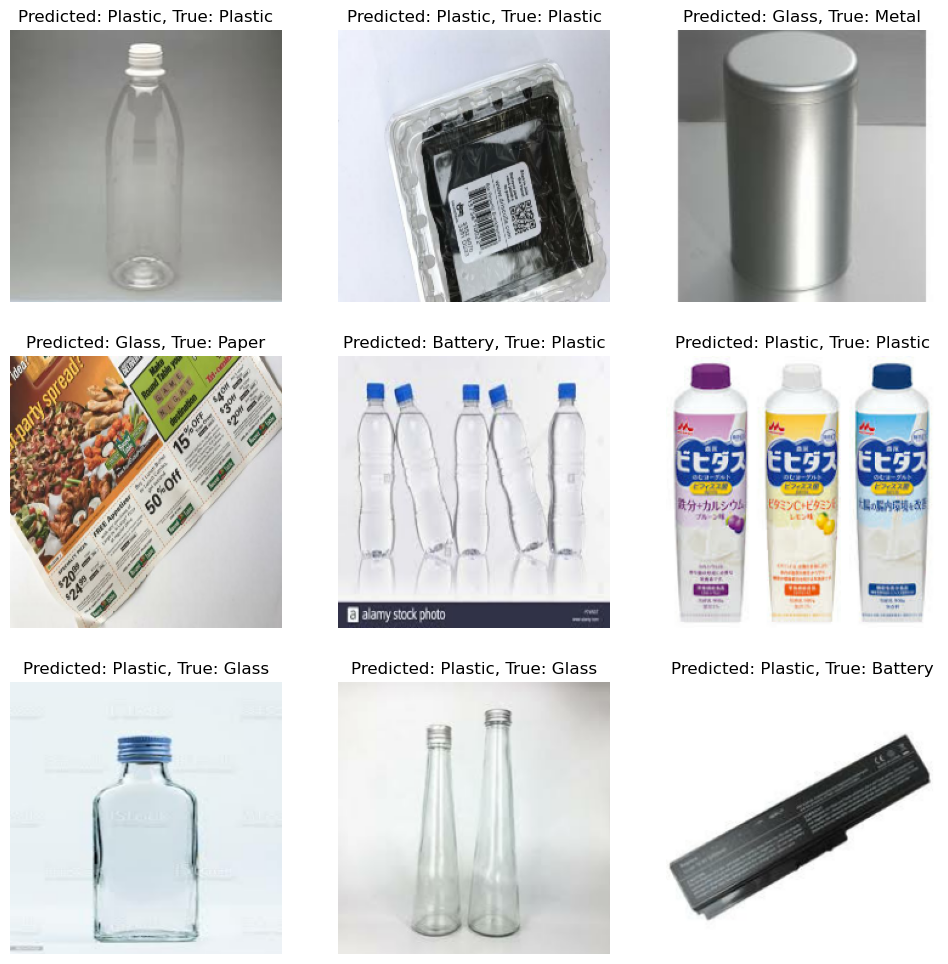

In [10]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

Como se puede notar, ha predicho de manera correcta 1/3 parte de este ejemplo, por lo que nos queda claro que hay algunas áreas a mejorar.

Por último, se evaluarán las métricas del modelo con el set de test, para conocer su desempeño real con imagenes no vistas

In [11]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_accuracy = modelo.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


22/22 [==============================] - 3s 138ms/step - loss: 1.7756 - accuracy: 0.4872
Test Loss: 1.7755892276763916, Test Accuracy: 0.4871794879436493


Como se puede notar, la evaluación regresó una pérdida de 1.322 y una precisión de 0.537, los cuales son valores bastante mejorables y que concuerdan con las predicciones no tan acertadas.

### Ajuste del modelo


Para mejorar igualmente el entrenamiento de la siguiente fase, se implementará un tercer callback: ReduceLROnPlateau. Este callback también es conocido como learning rate scheduler, y su función es el modificar el learning rate de acuerdo a un factor si es que durante el entrenamiento no mejora una métrica seleccionada durante una cantidad N de épocas.

In [12]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    
    factor=0.5,            
    patience=5,            
    min_lr=1e-6,           
    verbose=1              
)

Para mejorar el desempeño del modelo, se harán las siguientes modificaciones:

- En cuanto al Data augmentation, se reemplazo la rotación en 0.2 por un RandomBrightness y un Random Contrast, los dos en 0.2 ya que añaden variaciones en el contraste y brillo de las imágenes, lo que ayuda al modelo a ser más robusto frente a cambios en las condiciones de iluminación y contraste en las imágenes de prueba, además de que el aumento de datos mejora la capacidad de generalización del modelo al exponerlo a una mayor variedad de ejemplos durante el entrenamiento

- Por parte de la regularización y normalización, se redujo el valor de L2 a 0.0001 para prevenir el sobreajuste sin penalizar demasiado los pesos del modelo. La BatchNormalization por lotes ayuda a estabilizar y acelerar el entrenamiento al normalizar las activaciones de cada capa. Y finalmente, cambiar el tamaño del pool de 3x3 a 2x2 y ajustar los strides puede ayudar a preservar más información espacial en las primeras capas

- Se agregaron más capas convolucionales (128 y 256) con diferentes números de filtros permite al modelo aprender características más complejas y de mayor nivel

- Por parte de las Residual Units, se redujeron a 3 de 256, ya que no se quiere caer en una sobreparametrización, que habla del aprendizaje de patrones demasiado específicos de las imagenes de entrenamiento, afectando directamente en la capacidad de generalizar del modelo. Por otra parte, se busca eliminar la saturación de la red para no afectar las contribuciones de capas posteriores

- Por último, se aumentó el numero de unidades de la capa densa para permitir al modelo aprender representaciones más complejas. Además, se aumentó ligeramente la tasa de Dropout para prevenir el sobreajuste al desactivar más unidades durante el entrenamiento

In [16]:
def modelo_cnn_mejorado(num_classes=6):
    model = Sequential()
    
    model.add(Input(shape=(224, 224, 3)))
    
    model.add(RandomFlip("horizontal_and_vertical",input_shape=(224, 224, 3)))
    model.add(RandomContrast(0.2))
    model.add(RandomBrightness(0.2))
    
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3),padding='same',kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))

    model.add(Conv2D(64, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=2, strides=2))
    
    model.add(ResidualUnit(256, strides=2))
    model.add(ResidualUnit(256, strides=1))
    model.add(ResidualUnit(256, strides=2))

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.6))

    model.add(Dense(num_classes, activation='softmax'))

    return model

model_final = modelo_cnn_mejorado(num_classes=6)
model_final.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                         
                                                                 
 random_brightness_1 (Random  (None, 224, 224, 3)      0         
 Brightness)                                                     
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_32 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                      

Para compilar el modelo mejorado y, como se comentó anteriormente, el learning rate se redujo a 0.00001, se aumentó el número de épocas a 150 así como la tolerancia a 10 para dar más oportunidad al modelo de aprender sin cancelar el entrenamiento, además de utilizar los 3 callbacks explicados anteriormente.

In [17]:
model_final.compile(optimizer=Adam(learning_rate=0.00001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model_final.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=150,
    callbacks=[early_stopper,model_checkpoint,reduce_lr]
)

Epoch 1/150


102/102 [==============================] - 131s 1s/step - loss: 1.9265 - accuracy: 0.2137 - val_loss: 1.8215 - val_accuracy: 0.1710 - lr: 1.0000e-05
Epoch 2/150
 51/102 [==============>...............] - ETA: 1:12 - loss: 1.7956 - accuracy: 0.2653

KeyboardInterrupt: 

### Resultados

Una vez entrenado el modelo, analizaremos las gráficas respecto al comportamiento de la pérdida y la precisión para determinar si las modificaciones mejoraron el desempeño del modelo.

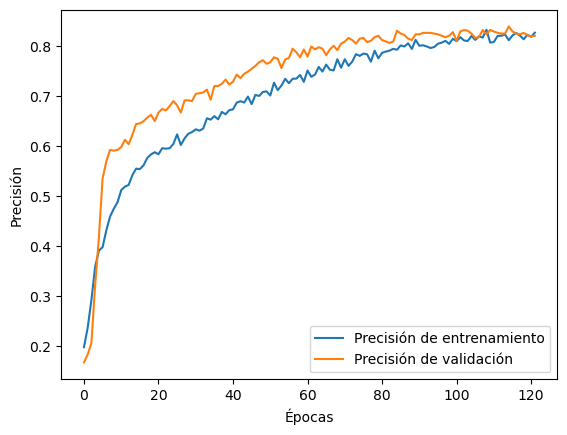

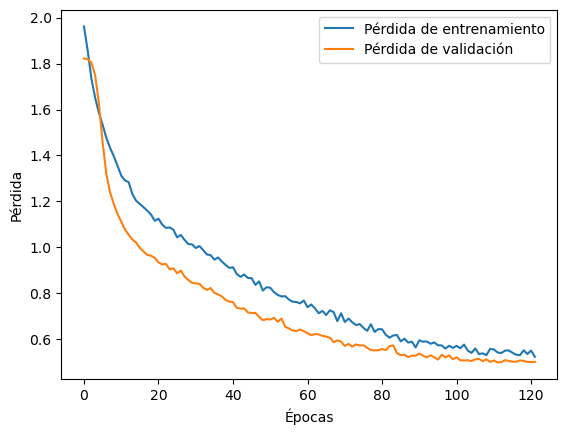

In [ ]:
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.show()

Segun las gráficas mostradas, se puede concluir que:

- Tanto la precisión como la pérdida ya no tienen su comportamiento tan inestable, ya que no se pueden apreciar picos y valles muy pronunciados, por lo que el aprendizaje es más estable conforme avanzan las épocas

- Los valores que se demuestran en las dos gráficas son mejores, ya que la precisión pasa de 0.80 y la pérdida es de menos de 0.6, aunque aún hay un margen de mejora en siguientes iteraciones

- La cercanía de las curvas de entrenamiento y validación conforme pasan las épocas nos indica que su capacidad de generalización mejora y que el sobreajuste se va reduciendo 



Ahora se carga la mejor versión guardada el modelo durante el entrenamiento, y se utiliza para realizar algunas predicciones con el set de test

In [ ]:
mejor_modelo = load_model('best_model_checkpoint.keras',custom_objects={'ResidualUnit': ResidualUnit})

predictions = mejor_modelo.predict(test_dataset)

predicted_classes = predictions.argmax(axis=1)

/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'residual_unit_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/python3.12/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'residual_unit_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/Users/gustavogutierrez/miniconda3/envs/Ambiente-Conda/lib/p

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step


Una vez hechas las predicciones, se hará uso de una matriz de confusión para notar que clases son las que más errores tienen, así como el comportamiento general del modelo con imágenes no antes vistas.

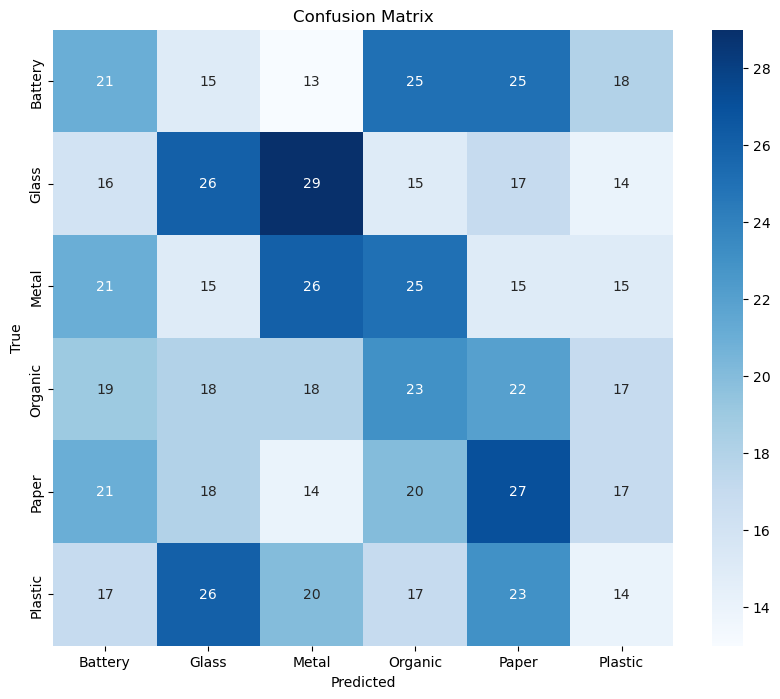

In [ ]:
y_true = np.concatenate([labels.numpy() for _, labels in test_dataset], axis=0)

conf_matrix = confusion_matrix(y_true, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Lo que se puede concluir de la matriz de confusión es lo siguiente:
- Una buena parte de los datos están dentro de las predicciones correctas, pero hay aun margen de mejora para reducir las predicciones erróneas
- La clase de plástico es la que más errores tiene, por lo que puede que sus imagenes tengan algunas características particulares que el modelo no alcanzó a detectar totalmente, mientras que en la demas clases tiene un comportamiento similar y mejor, pero si se identifican varios casos en los que la predicción no fue la correcta

Igualmente, se mostrarán algunas predicciones con su clase real, así como la imagen de cada una

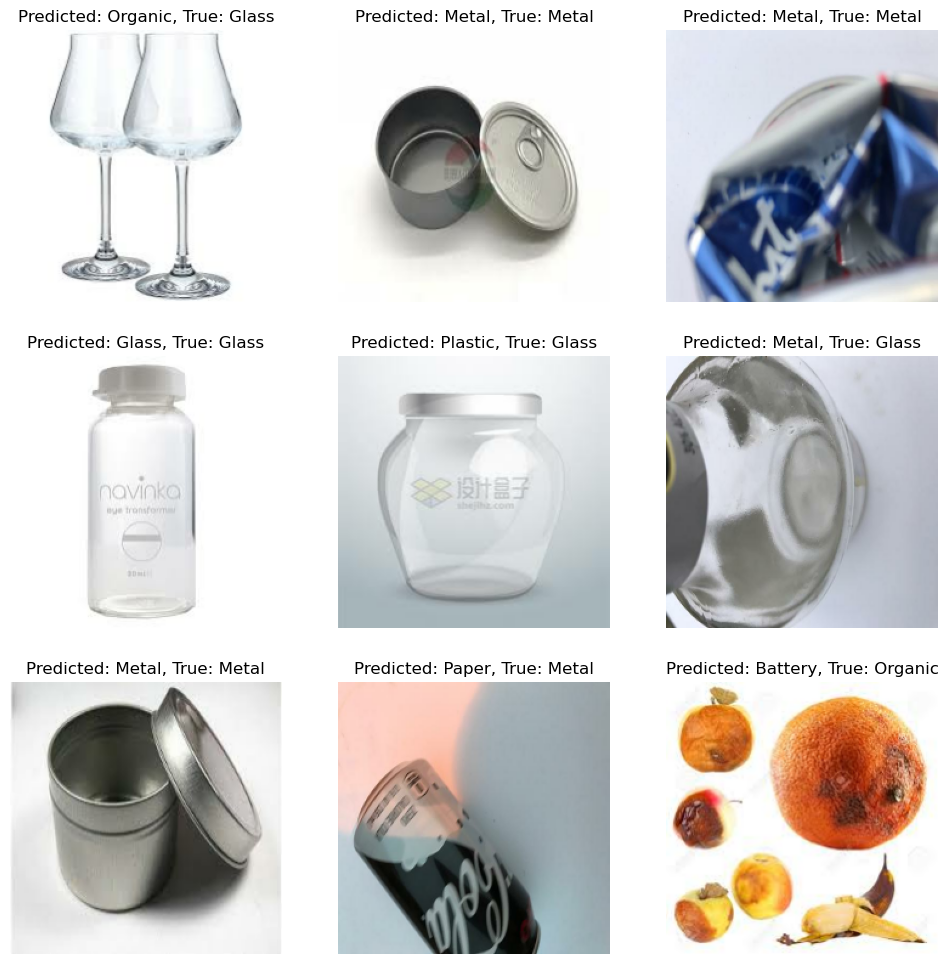

In [ ]:
def plot_predictions(dataset, predicted_classes, class_names):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            
            # Cambiar la forma en que se muestra la clase predicha y la verdadera
            plt.title(f"Predicted: {class_names[predicted_classes[i]]}, True: {class_names[labels[i]]}")
            plt.axis("off")
    plt.show()

# Visualizar algunas predicciones
plot_predictions(test_dataset, predicted_classes, class_names)

Como se puede notar, pudo realizar más predicciones correctas, por lo que ha habido una mejora en el modelo pero aún hay áreas de oportunidad para que todas las predicciones sean correctas. Se nota igualente que la clase metal es, en este ejercicio, la que más detecta de todas

Ahora podemos evaluar las métricas del modelo mejorado para entender de mejor manera su comportamiento con el dataset de test, que son imagenes que nunca ha visto.

In [ ]:
test_loss, test_accuracy = mejor_modelo.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 257ms/step - accuracy: 0.7959 - loss: 0.6438
Test Loss: 0.604865312576294, Test Accuracy: 0.8034188151359558


### Conclusión

Analizando los valores con el set de test, vemos que hubo una mejoría bastante notoria en las métricas debido a los cambios implementados, pero queda aún un margen de mejora que se puede tomar en cuenta para futuras modificaciones.

Parte de que la mejoría ha costado bastante en el modelo es la complejidad del dataset, ya que esta compuesto por imágenes con muchos colores y variaciones de iluminación, contraste, y ángulos de la camara, por lo que su análisis se complica bastante.

Una cuestión que se puede revisar es la calidad de las imagenes, ya que puede que algunas al ser redimensionadas no tengan la calidad necesaria para dar la información que se requiere en el entrenamiento. Por otra parte, el preprocesamiento de las imagenes puede ser un área de oportunidad para este modelo ya que podemos intentar aminorar lo más posible todas las diferencias entre las imagenes, para otorgar al modelo un dataset más representativo y valioso.

Otro aspecto que podría ayudar es el cambio del optimizador, ya que el uso de uno como AdamW que incorpora regularización y es mas rápido en general podría mejorar la etapa de entrenamiento.

Por lo tanto, debido a la complejidad de las imágenes y los casos de prueba, se puede decir que la mejoría del modelo ha sido notable, pero aún existen algunas técnicas pendientes que pueden ayudar a refinar los detalles que el modelo no ha podido superar, y conseguir el total de predicciones correctas.

### Aplicación

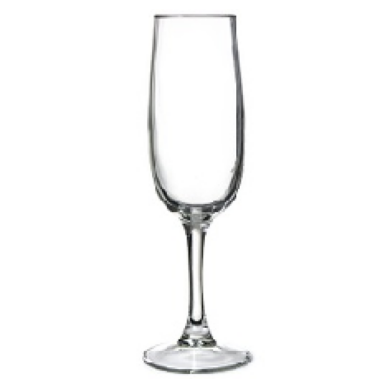

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
La imagen pertenece a la clase: Glass


In [ ]:
def predecir_clase(modelo, ruta_imagen, class_names, target_size=(224, 224)):

    img = load_img(ruta_imagen, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    plt.imshow(img)
    plt.axis('off')
    plt.show()

    prediccion = modelo.predict(img_array)
    clase_predicha = np.argmax(prediccion)
    
    print(f'La imagen pertenece a la clase: {class_names[clase_predicha]}')

    return class_names[clase_predicha]

aplicacion = predecir_clase(mejor_modelo, 'Aplicacion/copa.jpeg', ["Battery","Glass","Metal","Organic","Paper","Plastic"])

